In [44]:
from matplotlib import pyplot as plt
import platform, os, sys, string
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
reload(interpolate_slow)

<module 'BEMHelper.interpolate_slow' from '/Users/gkoolstra/Documents/Code/BEMHelper/interpolate_slow.py'>

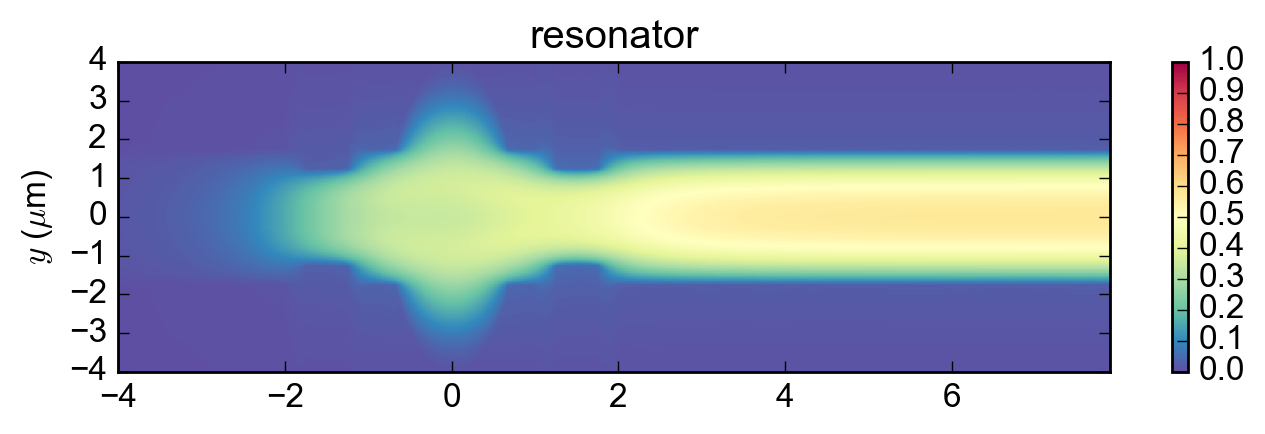

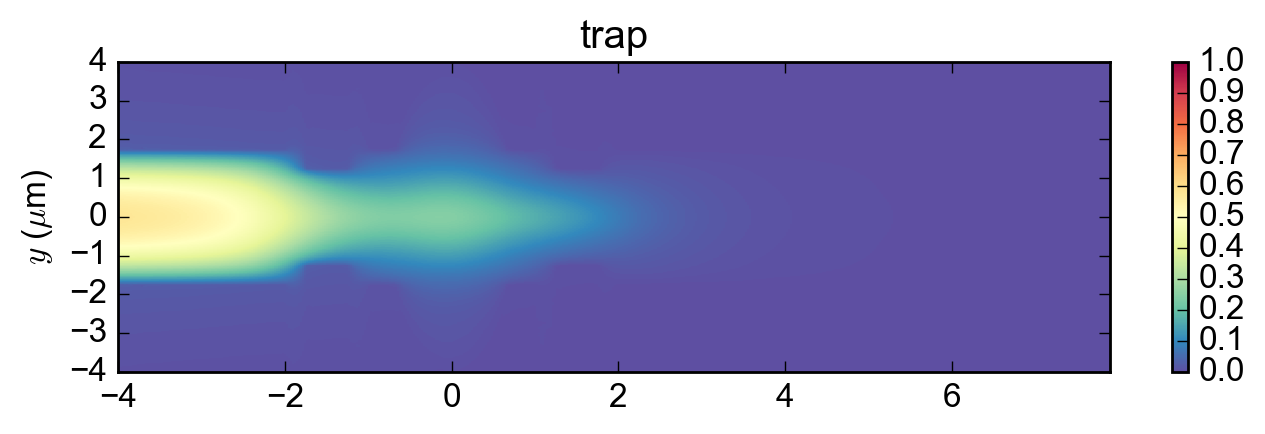

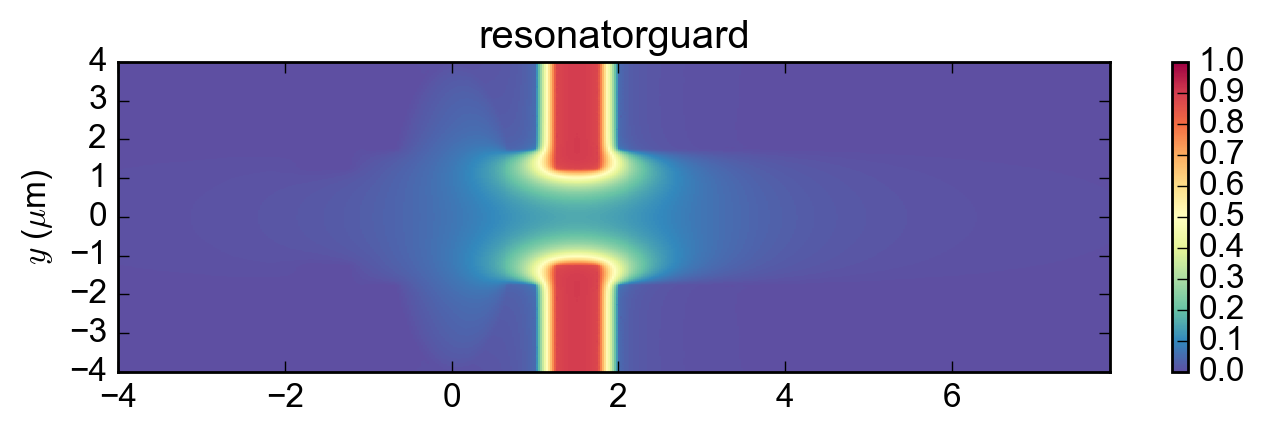

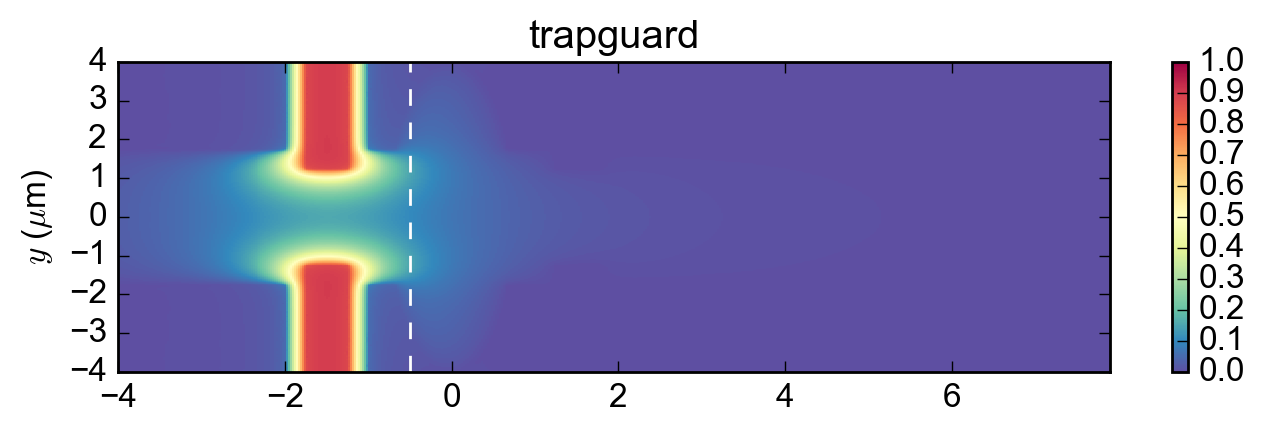

In [3]:
# Evaluate all files in the range
xeval = np.linspace(-4.0, 7.9, 501)
yeval = anneal.construct_symmetric_y(-4, 251)

save = True
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch"
datafiles = [os.path.join(save_path, "Resonator.dsp"),
             os.path.join(save_path, "Trap.dsp"),
             os.path.join(save_path, "ResonatorGuard.dsp"), 
             os.path.join(save_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
plt.figure(figsize=(14.,4.))
common.configure_axes(13)

x_eval, y_eval, output = anneal.load_data(save_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                         extend_resonator=False, do_plot=True, 
                                         inserted_res_length=0E-6)

plt.vlines(-0.5, np.min(yeval), -np.min(yeval), linestyles="--", color="white")

# How strong do electrodes contribute to barrier potential $V_b$?

We would like to describe the potential at the barrier in terms of the resonator voltage $V_r$ and the resonator guard $V_{rg}$: 

$$ V_b = \alpha V_{res} + \beta V_{trap} + \gamma V_{rg} + \delta V_{cg} + \epsilon V_{tg}$$

To find $\alpha$ through $\epsilon$ let's plot the energy across the channel when 1V is applied to each of the electrodes:

In [4]:
names = ['alpha', 'beta', 'gamma', 'delta']
voltage_coefficients = list()
xois = np.array(np.linspace(-4.0, 1.5, 101).tolist() + [7.0])
do_plot = False

for xoi in xois:
    xoi_idx = common.find_nearest(xeval, xoi)
    ctr_idx = common.find_nearest(y_eval[:,0], 0)

    if do_plot:
        fig = plt.figure(figsize=(10.,10.))

    for i in range(4):
        if do_plot:
            plt.subplot("32%d"%(i+1))
            plt.plot(y_eval[:,0]*1E6, -output[i]['V'][xoi_idx, :])
            if not i%2:
                plt.ylabel("Energy (-e$\phi$)")
            #if i in [4,5]:
            #    plt.xlabel("x ($\mu$m)")
            plt.title("%s at 1.0 V"%output[i]['name'])

        voltage_coefficients.append(output[i]['V'][xoi_idx, ctr_idx])
    
#if save: 
#    common.save_figure(fig, save_path=save_path)

(-4.0, 1.5)

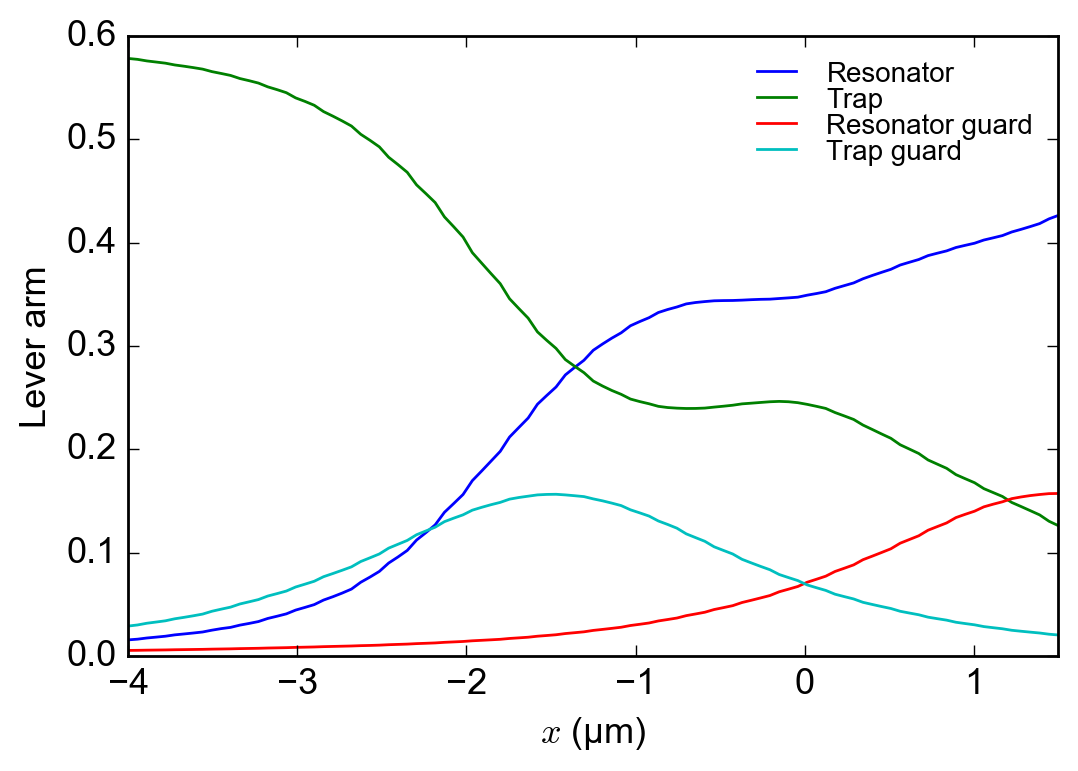

In [6]:
N = len(xois)

alphas = np.array(voltage_coefficients[::4])
betas = np.array(voltage_coefficients[1::4])
gammas = np.array(voltage_coefficients[2::4])
deltas = np.array(voltage_coefficients[3::4])

common.configure_axes(13)
plt.figure(figsize=(6.,4.))
plt.plot(xois, alphas, label=r"Resonator")
plt.plot(xois, betas, label=r"Trap")
plt.plot(xois, gammas, label=r"Resonator guard")
plt.plot(xois, deltas, label=r"Trap guard")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.xlabel("$x$ (%sm)"%(chr(956)))
plt.ylabel("Lever arm")

plt.xlim(xois[0], xois[-2])

(-4.0, 1.5)

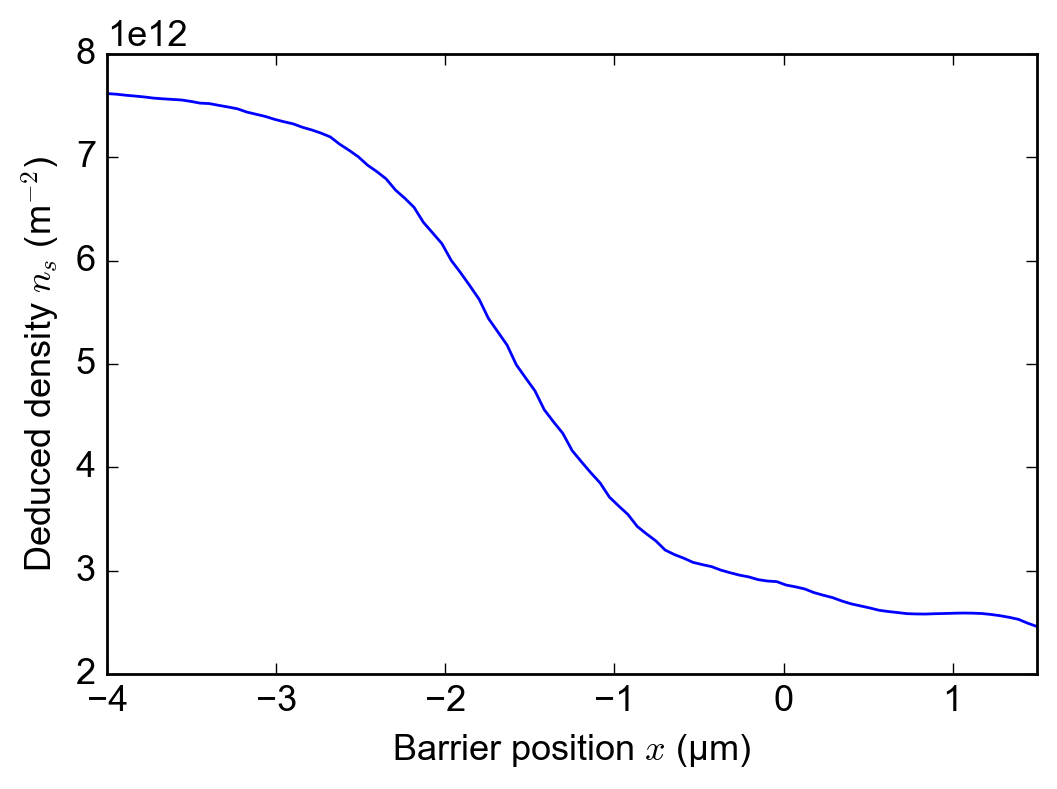

In [7]:
Vres = 0.6
Vtrap_th = 0.33

ns_th = 1.056 * 8.85E-12 / (1.602E-19 * 1.1E-6) * (Vres * (alphas[-1] - alphas[:-1]) - Vtrap_th * betas[:-1])

common.configure_axes(13)
plt.figure(figsize=(6.,4.))
plt.plot(xois[:-1], ns_th)
plt.xlabel("Barrier position $x$ (%sm)"%(chr(956)))
plt.ylabel("Deduced density $n_s$ (m$^{-2}$)")
plt.xlim(xois[0], xois[-2])

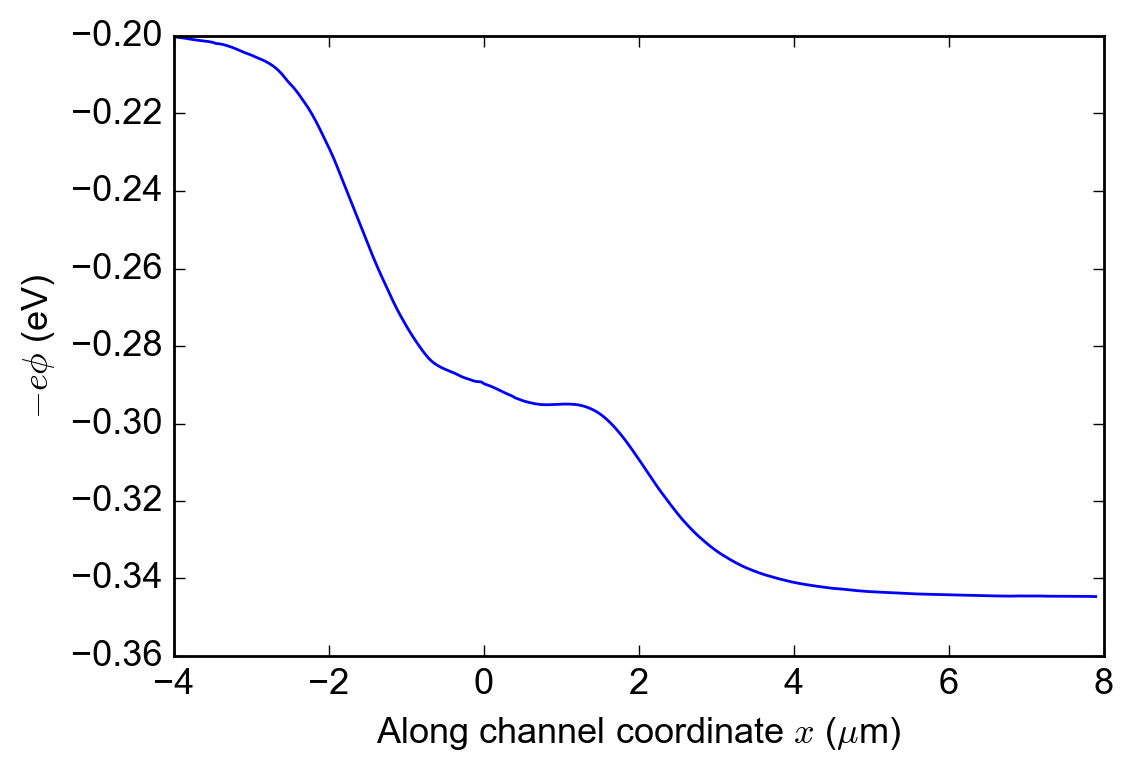

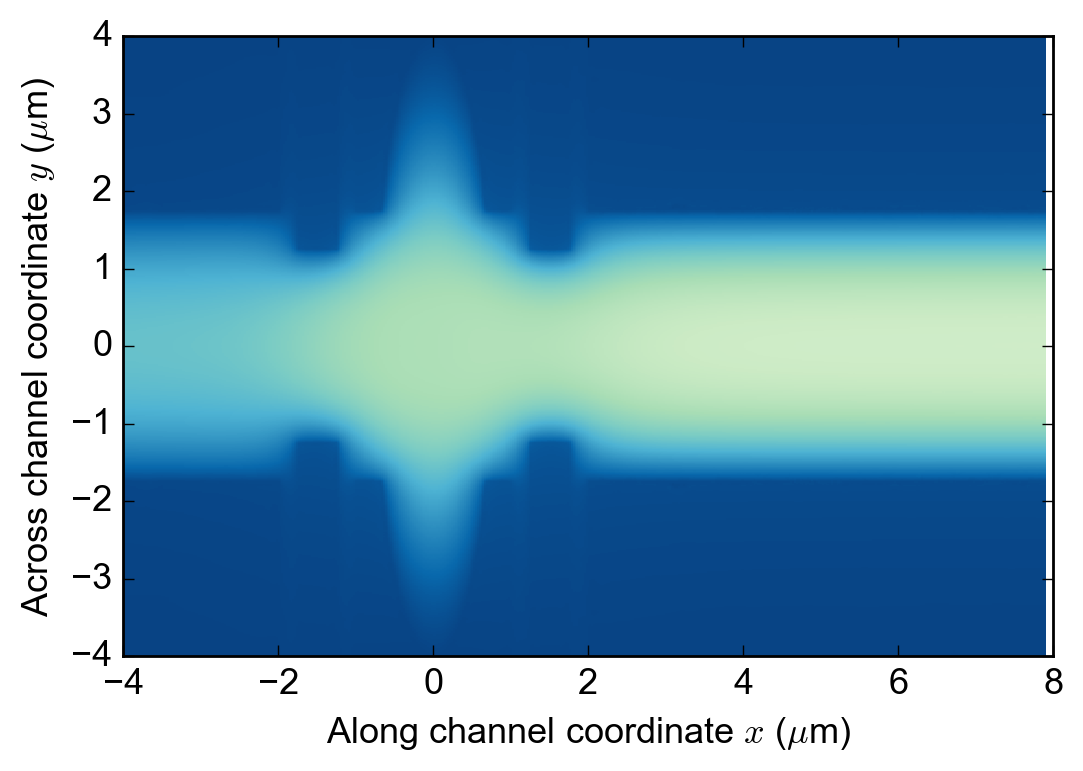

In [86]:
total_pot = - Vres * output[0]['V'] - Vtrap_th * output[1]['V']

plt.figure(figsize=(6.,4.))
plt.plot(x_eval[0, :]*1E6, total_pot[:, ctr_idx])
plt.xlabel("Along channel coordinate $x$ ($\mu$m)")
plt.ylabel(r"$-e\phi$ (eV)")

plt.figure(figsize=(6.,4.))
plt.pcolormesh(x_eval*1E6, y_eval*1E6, total_pot.T, cmap=plt.cm.GnBu, vmin=-0.75 * Vres, vmax=0.00)
plt.xlabel("Along channel coordinate $x$ ($\mu$m)")
plt.ylabel("Across channel coordinate $y$ ($\mu$m)")

# Electric fields in the y-direction

To figure out the loss through each electrode, we need the electric field in the across-channel direction, since this determines the coupling of the electron to the electrode. For the common mode, the $E_y$ for each electrode is determined by putting a symmetric combination of 1 V on each electrode. We then take the derivative in the y-direction of the simulated electrostatic potential. Any non-zero $E_y$ will result in a non-zero loss channel for the electron.

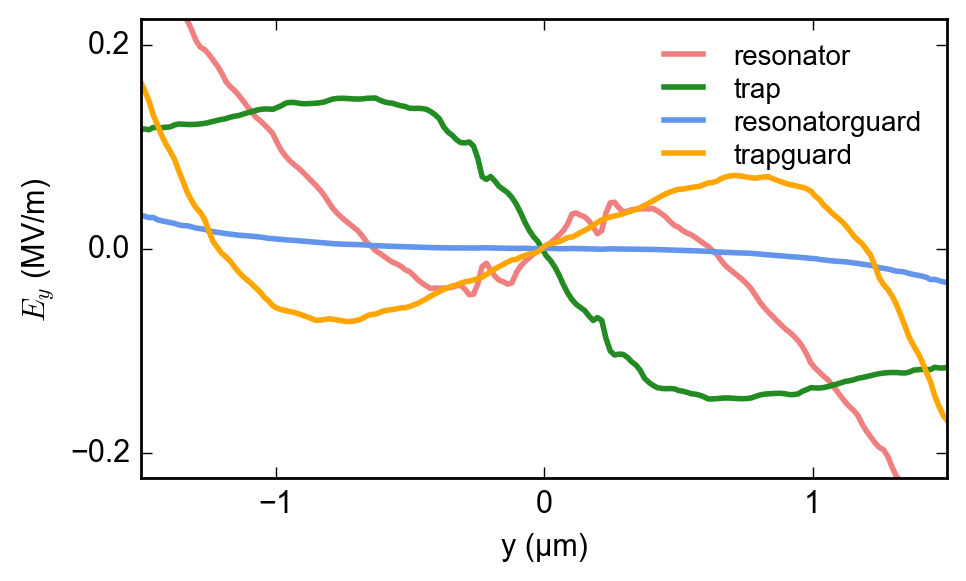

In [32]:
names = ['alpha', 'beta', 'gamma', 'delta']
voltage_coefficients = list()
xois = [-0.5] #np.array(np.linspace(-4.0, 1.5, 101).tolist() + [7.0])
do_plot = True

colors = ["lightcoral", "forestgreen", "cornflowerblue", "orange"]

for xoi in xois:
    xoi_idx = common.find_nearest(xeval, xoi)
    ctr_idx = common.find_nearest(y_eval[:,0], 0)

    if do_plot:
        fig = plt.figure(figsize=(5.,3.))
        common.configure_axes(11)
        ax2 = plt.gca()

    for i in range(4):
        if do_plot:
#             plt.subplot("32%d"%(i+1))
            ax2.plot(y_eval[:-1, 0] * 1E6, 1E-6 * np.diff(output[i]['V'][xoi_idx, :]) / np.diff(y_eval[:, 0]), 
                     label=output[i]['name'], color=colors[i], lw=2)
#             plt.grid('on')
            if not i%2:
                ax2.set_ylabel("$E_y$ (MV/m)")
#             plt.title("%s at 1.0 V"%output[i]['name'])
        
        voltage_coefficients.append(output[i]['V'][xoi_idx, ctr_idx])

ax2.legend(loc=0, frameon=False, prop={"size" : 10}, labelspacing=0.25)
ax2.set_xlim(-1.5, 1.5)
ax2.set_xticks([-1, 0, 1])
ax2.set_ylim(-0.225, 0.225)
ax2.set_yticks([-0.2, 0, 0.2])
ax2.set_xlabel("y (%sm)"%(chr(956)))
fig.tight_layout()

if 0: 
    common.save_figure(fig, save_path=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch - just trap/Ey Field Files")

Since the electron is located at $y=0$ and all electrodes have a zero of the electric field at this point, the coupling through any common mode should be negligible. Now, if the electron is offset from the center of the channel, it is clear that there will be some loss through mainly the trap electrode. 

Now let us investigate the differential mode. Instead of taking the derivative of the voltage, we explicitly export the electric fields in the y-direction for each electrode (for each simulation we put +/- 0.5 V on each electrode pair). Again, if an electrode's electric field $E_y$ at the electron's position is non-zero, there will be a loss channel through that electrode.

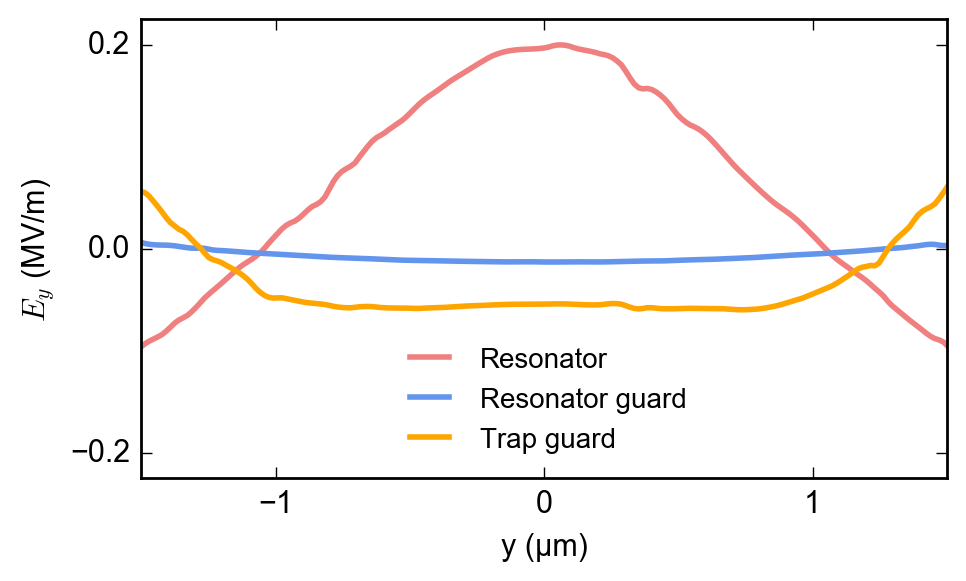

In [22]:
datapath = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch - just trap/Ey Field Files"

electrodes = ["Resonator", "Resonator guard", "Trap guard", "Center guard"]

files = ["ResonatorMode_Ey_xyplane.dsp",
         "ResonatorGuardMode_Ey_xyplane.dsp", 
         "TrapGuardMode_Ey_xyplane.dsp"]#, 
         #"CenterGuardMode_Ey_xyplane.dsp"]

colors = ["lightcoral", "cornflowerblue", "orange"]

inspect_2d_plots = 0

fig = plt.figure(figsize=(5.,3.))
common.configure_axes(11)

ax1 = plt.gca()

for i, file in enumerate(files):
    elements, nodes, elem_solution, bounding_box = anneal.load_dsp(os.path.join(datapath, file))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    yedge = bounding_box[3]
    xdata -= xcenter
    ydata -= yedge

    # Evaluate all files in the range
    xeval = np.linspace(-4.0, 8, 501)
    yeval = np.linspace(-14.0, -6.0, 501)
    # yeval = anneal.construct_symmetric_y(-4, 251)

    if xeval is None:
        xeval = xcenter + np.linspace(np.min(xdata), np.max(xdata), 101)
    if yeval is None:
        yeval = yedge + np.linspace(np.min(ydata), np.max(ydata), 101)

    if inspect_2d_plots:
        fig = plt.figure(figsize=(5.,2.))
        common.configure_axes(11)
        
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval,
                                                                  clim=(-2E5, 2E5), plot_axes='xy',
                                                                  cmap=plt.cm.RdBu_r, plot_mesh=0,
                                                                  plot_data=inspect_2d_plots)
    
    yinterp += 10
    yeval += 10
    
    xoi = -0.5
    xoi_idx = common.find_nearest(xeval, xoi)
    
    if not inspect_2d_plots:
        ax1.plot(yeval, Uinterp[:, xoi_idx]/1e6, lw=2, label=electrodes[i], color=colors[i])

if not inspect_2d_plots:
    ax1.set_xlabel("y (%sm)"%(chr(956)))
    ax1.set_ylabel("$E_y$ (MV/m)")
#     plt.xlim(np.min(yinterp), np.max(yinterp))
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-0.225, 0.225)
    ax1.legend(loc=0, prop={"size" : 10}, frameon=False, labelspacing=0.5)
#     plt.grid()
    ax1.set_xticks([-1, 0, 1])
    ax1.set_yticks([-0.2, 0, 0.2])
    fig.tight_layout()
    
if 0: 
    common.save_figure(fig, save_path=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch - just trap/Ey Field Files")

As should be expected, the resulting $E_y$ from the resonator is the largest of all electrodes. This means a single electron couples strongest to the resonator. After this, this data says that the trap guard couples strongest, followed by the resonator guard. The center guard is included in this, even though it is part of the ground plane in our device, which means coupling through this should in principle be absent. 

Note that the coupling through the trap guard is about 4x smaller than the coupling to the resonator. Also remember that there are filters in the trap guard and resonator guard that should prevent excitation of a mode at the electron frequency. 

**The conclusion is that the loss rate $\Gamma$ through electrodes other than the resonator cannot be more than the coupling strength $g$ to the resonator**

# Combined into one plot

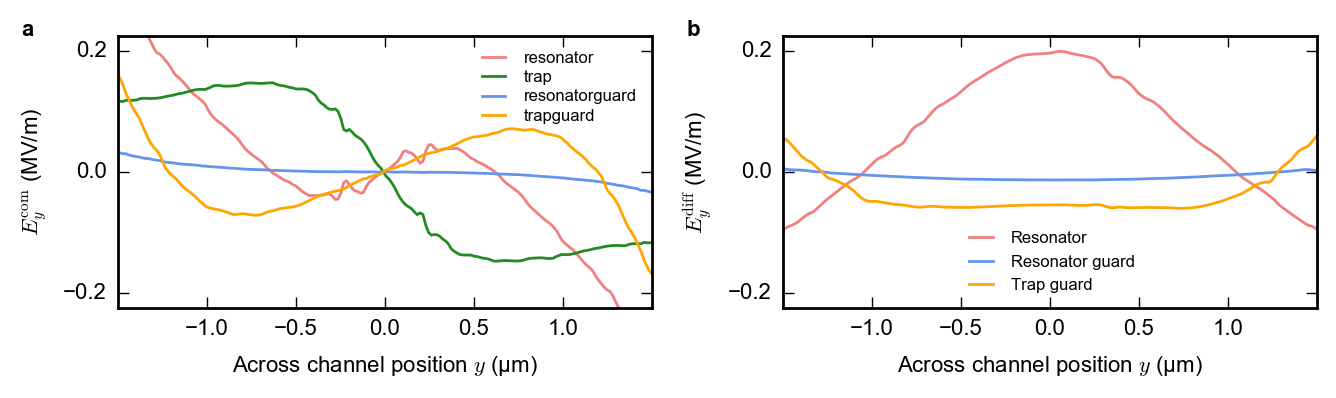

In [60]:
names = ['alpha', 'beta', 'gamma', 'delta']
voltage_coefficients = list()
xois = [-0.5] #np.array(np.linspace(-4.0, 1.5, 101).tolist() + [7.0])
do_plot = True
fontsize = 8

colors = ["lightcoral", "forestgreen", "cornflowerblue", "orange"]

for xoi in xois:
    xoi_idx = common.find_nearest(xeval, xoi)
    ctr_idx = common.find_nearest(y_eval[:,0], 0)

    if do_plot:
        fig = plt.figure(figsize=(6.75, 2.))
        common.configure_axes(fontsize)
        ax2 = fig.add_subplot(1, 2, 1)
        ax1 = fig.add_subplot(1, 2, 2)

    for i in range(4):
        if do_plot:
#             plt.subplot("32%d"%(i+1))
            ax2.plot(y_eval[:-1, 0] * 1E6, 1E-6 * np.diff(output[i]['V'][xoi_idx, :]) / np.diff(y_eval[:, 0]), 
                     label=output[i]['name'], color=colors[i], lw=1.0)
#             plt.grid('on')
            if not i%2:
                ax2.set_ylabel("$E_y^{\mathrm{com}}$ (MV/m)")
#             plt.title("%s at 1.0 V"%output[i]['name'])
        
        voltage_coefficients.append(output[i]['V'][xoi_idx, ctr_idx])

ax2.legend(loc=0, frameon=False, prop={"size" : fontsize-2}, labelspacing=0.25)
ax2.set_xlim(-1.5, 1.5)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.set_ylim(-0.225, 0.225)
ax2.set_yticks([-0.2, 0, 0.2])
ax2.set_xlabel("Across channel position $y$ (%sm)"%(chr(956)))

########################################

datapath = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch - just trap/Ey Field Files"

electrodes = ["Resonator", "Resonator guard", "Trap guard", "Center guard"]

files = ["ResonatorMode_Ey_xyplane.dsp",
         "ResonatorGuardMode_Ey_xyplane.dsp", 
         "TrapGuardMode_Ey_xyplane.dsp"]#, 
         #"CenterGuardMode_Ey_xyplane.dsp"]

colors = ["lightcoral", "cornflowerblue", "orange"]
inspect_2d_plots = 0

for i, file in enumerate(files):
    elements, nodes, elem_solution, bounding_box = anneal.load_dsp(os.path.join(datapath, file))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    yedge = bounding_box[3]
    xdata -= xcenter
    ydata -= yedge

    # Evaluate all files in the range
    xeval = np.linspace(-4.0, 8, 501)
    yeval = np.linspace(-14.0, -6.0, 501)
    # yeval = anneal.construct_symmetric_y(-4, 251)

    if xeval is None:
        xeval = xcenter + np.linspace(np.min(xdata), np.max(xdata), 101)
    if yeval is None:
        yeval = yedge + np.linspace(np.min(ydata), np.max(ydata), 101)

    if inspect_2d_plots:
        fig = plt.figure(figsize=(5.,2.))
        common.configure_axes(11)
        
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval,
                                                                  clim=(-2E5, 2E5), plot_axes='xy',
                                                                  cmap=plt.cm.RdBu_r, plot_mesh=0,
                                                                  plot_data=inspect_2d_plots)
    
    yinterp += 10
    yeval += 10
    
    xoi = -0.5
    xoi_idx = common.find_nearest(xeval, xoi)
    
    if not inspect_2d_plots:
        ax1.plot(yeval, Uinterp[:, xoi_idx]/1e6, lw=1.0, label=electrodes[i], color=colors[i])

if not inspect_2d_plots:
    ax1.set_xlabel("Across channel position $y$ (%sm)"%(chr(956)))
    ax1.set_ylabel("$E_y^{\mathrm{diff}}$ (MV/m)")
#     plt.xlim(np.min(yinterp), np.max(yinterp))
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-0.225, 0.225)
    ax1.legend(loc=0, prop={"size" : fontsize-2}, frameon=False, labelspacing=0.5)
#     plt.grid()
    ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax1.set_yticks([-0.2, 0, 0.2])
    fig.tight_layout()

for n, ax in enumerate([ax2, ax1]):
    ax.text(-0.18, 1.00, string.ascii_lowercase[n], transform=ax.transAxes, size=fontsize, weight='bold')
    
if 1: 
    sp = r"/Volumes/slab/Gerwin/Electron on helium/Papers/2017 - Circuit QED with a single electron on helium/Supplement"
    fig.savefig(os.path.join(sp, "FigS13.pdf"), dpi=300, pad_inches=0)